## Introduction

This notebook illustrates how we can use NER to search for placenames in a corpus, and enhance a gazetteer. It uses two datesets to illustrate the concepts.

1) [Geograph](https://geograph.org.uk) 
This site invites users to take pictures in the UK and add descriptions. It has almost 7 million pictures, and the data are licenced using a CC By-SA licence, making them available for research as long as we keep the names of the users, and allow others to have access to any data we might create.

2) [Ordnance Survey](https://ordnancesurvey.co.uk/) 50k gazetteer
This gazetteer was published under a UK Open Government licence and contains all place name found on 1:50k maps in the UK. It is a legacy product (i.e. not used or updated any more), but it is suitable for our purposes.

We are going to look for names found in the Geograph data that don't exist in the gazetteer. Since we know that many names occur multiple times, we will do this locally, to increase the chances that we really find new names.

**The first block of our code reads in data and builds a simple spatial index for the gazetteer. We only need to do this once.**

In [14]:
import OSGridConverter #To convert from =SGB36 to WGS84
import pandas as pd #To use pandas for elegant data handling
import spacy #Our NLP tools
import matplotlib.pyplot as plt #To plot results


import os #We import os to stop a weird kernel crash...
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

#Load a language model to do NLP
nlp = spacy.load("en_core_web_sm")

In [15]:
#First we read in the geograph data
geograph = pd.read_csv('./data/geograph_mini_corpus.csv')
geograph.head()

,id,author,title,text,lon,lat
0,2749148,M J Richardson,Great Blasket Island - 1960,Looking northeast along the northwestern side ...,-10.534101,52.097794
1,635105,Bob Shires,White Beach Great Blasket,The only beach on Great Blasket as seen from t...,-10.514872,52.107609
2,635109,Bob Shires,Remaining homes on Great Blasket,The remaining few habited homes of the abandon...,-10.511764,52.104260
3,259349,Nigel Cox,Coumeenoole Bay,Viewed looking back from the Dunmore Head head...,-10.463579,52.109322
4,16917,Pam Brophy,Clogher Beach,The exact gpr for this beach is Q3153003375. T...,-10.463338,52.157867


In [16]:
#Read in the Ordnance Survey gazetteer
os_50k = pd.read_csv('./data/50kgaz2012.txt',sep=':', encoding='utf8', header=None)
os_50k.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,TQ6004,1066 Country Walk,TQ60,50,49.0,0,16.7,104500,560500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
1,2,TQ7715,1066 Country Walk,TQ60,50,54.7,0,31.5,115500,577500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
2,3,TQ7610,1066 Country Walk Bexhill Link,TQ60,50,52.0,0,30.5,110500,576500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
3,4,TQ8315,1066 Country Walk Hastings Link,TQ80,50,54.5,0,36.6,115500,583500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
4,5,NB5464,A' Beirghe,NB46,58,30.0,6,12.9,964500,154500,W,WI,N Eil,Na h-Eileanan an Iar,X,21-JAN-2003,U,8,0,0


<AxesSubplot:xlabel='x', ylabel='y'>

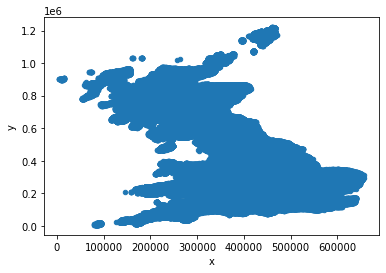

In [17]:
#We need to create locations for each place name in decimal degrees
os_50k[20] = os_50k[4] + os_50k[5]/60
os_50k[21] = os_50k[6] + os_50k[7]/60
os_50k.loc[os_50k[10] == 'W', 21] = -1 * os_50k.loc[os_50k[10] == 'W', 21]

#Tidy up the gazetteer by dropping columns we won't use afterwards
os_trimmed = os_50k.drop([0,1,3,4,5,6,7,10,11,12,14,15,17,18,19], axis = 1)
os_trimmed.head()
os_trimmed.columns = ['name','y','x',
                     'county','type','lat','lon']
os_trimmed.head()

#Plot the gazetteer locations as a sanity check
os_trimmed.plot.scatter(x = 'x', y = 'y')

In [18]:
#We build a simple index using rectangular grid cells
#Each cell contains all placenames from the gazetteer for that cell and can be used to do a lookup
#cellSize determines the resolution in metres

cellSize = 10000
minx = os_trimmed['x'].min()
maxx = os_trimmed['x'].max()
miny = os_trimmed['y'].min()
maxy = os_trimmed['y'].max()

w = maxx - minx
h = maxy - miny

nc = int(w/cellSize) + 1
nr = int(h/cellSize) + 1

gaz = pd.DataFrame(index=range(nc),columns=range(nr))

In [19]:
#Now we populate the index with names
for index, row in os_trimmed.iterrows():
    i = int((row['x'] - minx)/cellSize)
    j = int((row['y'] - minx)/cellSize)
    name = row['name']
    
    if pd.isnull(gaz.at[i,j]):
        gaz.at[i,j] = {name}
    else:
        names = gaz.at[i,j]
        names.add(name)
        gaz.at[i,j] = names

In [20]:
#Example output for a single cell - returns nan if no names present
gaz.at[20,20]

{'Atheston',
 'Barre',
 'Begelly',
 "Bishop's Br",
 'Black Moor',
 'Blackaldern',
 'Blackpool',
 'Blaencilgoed Fm',
 'Blaengwaithnoah',
 'Bluestone',
 'Brince',
 'Broadmoor',
 'Broom',
 'Bryn Hill',
 'Camp Hill',
 'Campshill Fm',
 'Canaston',
 'Canaston Wood',
 'Captain Style',
 'Carew Mountain',
 'Carne',
 'Castell Coch',
 'Catershook',
 'Chapel Hill',
 'Churchton',
 'Cilrhiw Ho',
 'Cloverhill Fm',
 'Cold Blow',
 'Cold Inn',
 'Coppet Hall Pt',
 'Cott Fm',
 'Cowsland',
 'Cresselly',
 'Cresselly Big Wood',
 'Cresswell Quay',
 'Crinow',
 'Cross Hands',
 'Dawes Fm',
 'Dinaston',
 'Dyffryn Fm',
 'Eweton',
 'Flimston',
 'Folly Fm',
 'Freestone Hall',
 'Gloyne Fm',
 'Glyn Patel',
 'Great Molleston Fm',
 'Grove, The',
 'Hackett',
 'Hean Cas',
 'High Toch',
 'Highgate',
 'Hill',
 'Holy Well',
 'Honeys Croft',
 'Jeffreyston',
 'Kilgetty',
 'Kilgetty Fm',
 "King's Moor",
 'Knaps',
 'Lanesend',
 'Langdon',
 'Llan-mill',
 'Longstone',
 'Longstone, The',
 'Loveston',
 'Ludchurch',
 'Martin Hill',
 

This block is just to show the NLP results for a single document

In [21]:
#First we demonstrate how the NLP works for a single example document
doc = nlp(geograph.text[20])
spacy.displacy.render(doc, style="ent")
doc_nouns = list(doc.noun_chunks)
print("nouns:",doc_nouns)
for ent in doc.ents:
      print("NER:", ent.text, ent.label_)
          

nouns: [Ballyferriter, the north eastern section, the grid square, the R559 (Dingle Way, a view, the southern end, the town]
NER: Ballyferriter PERSON
NER: R559 PRODUCT
NER: Dingle Way PERSON


The code from here on does the matching. Since we **draw a random sample of documents** from the Geograph data every time, the **results will also vary**. Rerun the code to see how the proportion of names found and their types vary.

In [22]:
#Now I am going to load a random sample of m Geograph documents
m= 200
sample = geograph.sample(n = m)
docs = list(nlp.pipe(sample.text,n_process=2, batch_size=100))

#Now we store the NER results with the original geograph document ids, text and coordinates
results = list()
for (idxRow, s1), (_, s2) in zip(sample.iterrows(), enumerate(docs)):
    try:
        g = OSGridConverter.latlong2grid (s1.lat, s1.lon, tag = 'WGS84')
        dict = {
            "id": s1.id,
            "x": g.E,
            "y": g.N,
            "entities": s2.ents,
            "text": s1.text   
        }
        results.append(dict)
    except ValueError:
        print("Problem with a document", s1.text)
        #Ignore documents we couldn't parse for some reason

Problem with a document 0


In [23]:
#Show the results - these are essentially all the NER tokens found in each document
for dict in results:
    print(dict.get("id"), dict.get("x"), dict.get("y"), dict.get("entities"))

1197855 453879 1202990 (Cullivoe, Cullivoe Hall)
830586 462490 121140 (Garden Hill Lane, the South Downs Way)
311653 564699 166650 (Meopham village, Meopham Court)
2261777 524799 152000 (the North Downs, Colley Hill)
1789068 296886 112621 (Temple Crescent,)
2574766 264160 854890 (Balnakyle Farm, one)
2013979 377570 417010 (the Peel Monument, Holcombe Hill)
1582571 352600 617300 (Winter, Courthill Farm, Minto Hill)
21723 413800 265800 (Ullenhall, Henley, Arden - Redditch, Hunger Hill)
371727 352100 336300 (Whixall village,)
1483973 486969 193320 (Amersham Hill,)
2540883 336289 405180 (Lydiate Hall,)
1110810 639469 312600 (Cargate Lane, Church Road)
2436317 458839 508290 (the River Leven,)
186227 275360 92380 (A30,)
200038 289099 771600 ()
1608156 421499 376500 (The Square,)
535027 135587 514802 (Hillsborough Fort,)
1239511 89042 265805 (Kilmore,)
1383955 448300 271200 ()
635894 355329 217200 (NHS, The Doward hill, A40)
517509 112486 467575 ()
2900703 259610 579110 (A762,)
3000948 344490

In [24]:
#Now we are going to compare the gazetteer names with those we found

data = list()
#We iterate through all our results
for dict in results:
    #First we get the cell indices for the gazetteer
    x = dict.get("x")
    y = dict.get("y")
    i = int((x - minx)/cellSize)
    j = int((y - minx)/cellSize)
    try:
        #Now we find the names in that cell - n.B. we ignore for now the fact that Geograph cell could be at a boundary
        gazNames = gaz.at[i,j]
        #Deal with a cell having no values in the gazetteer
        if (isinstance(gazNames,set) == False): 
            #print(type(gazNames))
            gazNames = {"NoNamesFound"}
    except KeyError:
        gazNames = {"NoNamesFound"}
    #Get back the named entities for the text        
    ents = dict.get("entities")
    #Now we iterate through, and find out if each name is already in the local gazetteer
    for ent in ents:        
        if (ent.text in gazNames):
            data.append([dict.get("id"), "Existing", ent.text, ent.label_, x, y]) 
            #print("Found existing name:", ent.text, ent.label_)
        else:
            #print("Potential new name:" , ent.text, ent.label_)
            data.append([dict.get("id"), "New", ent.text, ent.label_, x, y]) 
#Store the results in a dataframe
df = pd.DataFrame(data, columns = ['id', 'status','name','type','x','y'])
df

,id,status,name,type,x,y
0,1197855,Existing,Cullivoe,ORG,453879,1202990
1,1197855,New,Cullivoe Hall,ORG,453879,1202990
2,830586,New,Garden Hill Lane,FAC,462490,121140
3,830586,New,the South Downs Way,ORG,462490,121140
4,311653,New,Meopham village,GPE,564699,166650
...,...,...,...,...,...,...
289,20093,New,the Pentland Hills,LOC,308939,646860
290,1704145,New,Dene Hollow,PERSON,449050,186000
291,889615,Existing,Bathford Hill,GPE,375769,166110
292,889615,Existing,Bathford,ORG,375769,166110


In [25]:
#Split results into existing and candidate names for reporting
new = df.loc[df['status'] == 'New']
existing = df.loc[df['status'] == 'Existing']

Text(0.5, 1.0, 'Counts for existing names')

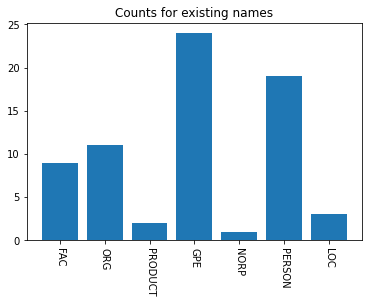

In [26]:
#Create a bar plot of existing names
count = list()
values = list()
for value in set(existing['type']):
    count.append(list(existing['type']).count(value))
    values.append(value)
y_pos = range(len(values))
p = plt.bar(y_pos,count)
# Rotation of the bars names
plt.xticks(y_pos, values, rotation=270)
plt.title('Counts for existing names')

Text(0.5, 1.0, 'Counts for candidate new names')

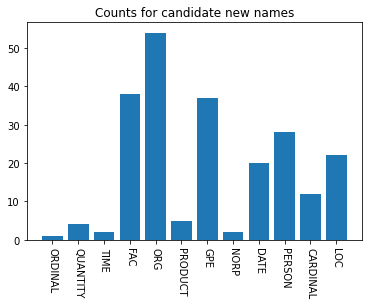

In [27]:
#Create a bar plot of new names
count = list()
values = list()
for value in set(new['type']):
    count.append(list(new['type']).count(value))
    values.append(value)
y_pos = range(len(values))
p = plt.bar(y_pos,count)
# Rotation of the bars names
plt.xticks(y_pos, values, rotation=270)
plt.title('Counts for candidate new names')

In [28]:
#Let's look at one example NER class in the candidate names
names = existing.loc[existing['type'] == 'GPE']

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(names)

          id    status            name type       x       y
40    750700  Existing          Dundee  GPE  339200  734500
43   1160833  Existing         Maisley  GPE  341909  850120
45   1110566  Existing        Goodrich  GPE  357340  220020
112   372874  Existing        Hilldyke  GPE  534420  347580
120  3318588  Existing       Kingswood  GPE  364750  173850
124  3110164  Existing           Hythe  GPE  442070  110620
125  3110164  Existing     Southampton  GPE  442070  110620
139  3306570  Existing    Throckmorton  GPE  398330  248920
143   587774  Existing          Lanark  GPE  286890  644450
147  2218405  Existing        Ewe Hill  GPE  400270  616580
148  2218405  Existing          Ingram  GPE  400270  616580
152    49871  Existing     Hipton Hill  GPE  403500  248500
157  2428872  Existing       Moss Hill  GPE  330220  818080
176   246923  Existing         Gipping  GPE  607179  265200
194   219981  Existing  Mauldslie Hill  GPE  331699  652400
226   507137  Existing        Winksley  

In [29]:
cn = len(set(new['name']))
ce = len(set(existing['name']))
print("Found ", ce, " unique existing names and ", cn, " unique new names.")

Found  68  unique existing names and  213  unique new names.


In [30]:
#output all dependencies so that we can reproduce the notebook (we only need this to set things up for Binder)
#%load_ext watermark
#%watermark --iversions